# Identification of selective sweeps

## Setup

In [1]:
# Load require packages
library(tidyverse)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
# Prefix for results
results_prefix <- '/scratch/projects/trifolium/gwsd/results/'

### Functions

In [15]:
# Function to load windowd thetas 
load_windowed_thetas <- function(path){
    habitat <- str_extract(basename(path), '(?<=allSites_)(\\w+)(?=_windowed)')

    df <- suppressMessages(read_delim(path, delim = '\t')) %>%
        mutate(tp_scaled = tP / nSites,
               habitat = habitat) %>%
        dplyr::select(-tF, -tH, -tL, -fuf, -fud, -fayh, -zeng, -tW, -tP, -starts_with('#'))
    return(df)
}

# Function to load windowed Fst
load_windowed_fst <- function(path){
    chrom <- str_extract(basename(path), '^(.+)(?=_allSites)')
    hab_comb <- str_extract(basename(path), '(?<=allSites_)(\\w+_\\w+)(?=_windowed)')
    
    colnames <- c('region', 'Chr', 'WinCenter', 'nSites_fst', 'fst')
    df <- suppressMessages(read_delim(path, delim = '\t', skip = 1, col_names = colnames)) %>%
        
        # Set negative Fst values to 0
        mutate(fst = ifelse(fst < 0, 0, fst))
    
    return(df)
}

## SFS-based tests

- I estimated $\theta_{\pi}$, Tajima's D, and $F_{ST}$ in 5 Kb windows across the genome with a 1 Kb step
- For each window, I will estimate the difference in $\theta_{\pi}$ and Tajima's D between urban and rural habitats (i.e., $\Delta\theta_{\pi}$ and $\Delta$Td)
- I'll define outlier regions as those with:
    1. Lower/Higher $\Delta\theta_{\pi}$ than the genome-wide average
    2. Lower/Higher $\Delta$Td than the genome-wide average
    3. Higher $F_{ST}$ than the genome-wide average

In [16]:
# Load Fst
fst_path <- paste0(results_prefix, 'angsd/summary_stats/hudson_fst/byHabitat/allSites')
fst_df <- list.files(fst_path, recursive = TRUE, full.names = TRUE, pattern = '.+_allSites_Urban_Rural_windowed.fst') %>%
    purrr::map_dfr(., load_windowed_fst) %>%
    mutate(region = paste(Chr, '_', WinCenter))

In [17]:
# Remove windows with less than 2000 sites contributing to Fst estimate
# total_windows_fst <- nrow(fst_df)

# nSites_thresh <- 2000
# fst_df_filt <- fst_df %>%
#     filter(fst_nSites >= nSites_thresh) %>%
#     mutate(region = paste(Chr, '_', WinCenter))
# total_windows_fst_filt <- nrow(fst_df_filt)

# print(sprintf('%s windows contained less than %s sites. %s windows remaining', total_windows_fst - total_windows_fst_filt, nSites_thresh, total_windows_fst_filt))

In [18]:
# Load summary stats
# Currently ignores suburban habitats
thetas_path <- paste0(results_prefix, 'angsd/summary_stats/thetas/byHabitat/allSites')
thetas_df <- list.files(thetas_path, recursive = TRUE, pattern = '.+_allSites_(Rural|Urban)_windowedThetas.gz.pestPG', full.names = TRUE) %>%
    purrr::map_dfr(., load_windowed_thetas)

In [19]:
# Convert to wide format for calculating habitat differences, etc
thetas_df_wide <- thetas_df %>% 
    pivot_wider(values_from = c('Tajima', 'nSites', 'tp_scaled'), names_from = 'habitat') %>%
    mutate(region = paste(Chr, '_', WinCenter))

In [22]:
# Combine windowed theta and fst estimates into single df
# Calculate difference in pi and Tajima's D
total_windows_theta <- nrow(thetas_df_wide)
total_windows_fst <- nrow(fst_df)

allStats_windowed_df <- thetas_df_wide %>%
    filter(region %in% fst_df$region) %>%
    left_join(., fst_df, by = c('region', 'Chr', 'WinCenter')) %>%
    mutate(delta_tp_ur = tp_scaled_Urban - tp_scaled_Rural,
           delta_td_ur = Tajima_Urban - Tajima_Rural) %>%
    dplyr::select(region, everything())

total_windows_allStats <- nrow(allStats_windowed_df)

print(sprintf('There are %s windows with estimates of fst and %s windows with estimates of thetas', total_windows_fst, total_windows_theta))
print(sprintf('%s windows were missing from the Fst Dataframe. %s windows remaining', total_windows_theta - total_windows_allStats, total_windows_allStats))

[1] "There are 806851 windows with estimates of fst and 892381 windows with estimates of thetas"
[1] "85530 windows were missing from the Fst Dataframe. 806851 windows remaining"


In [37]:
testChr_allStats <- allStats_windowed_df %>%
    filter(Chr == 'CM019103.1')

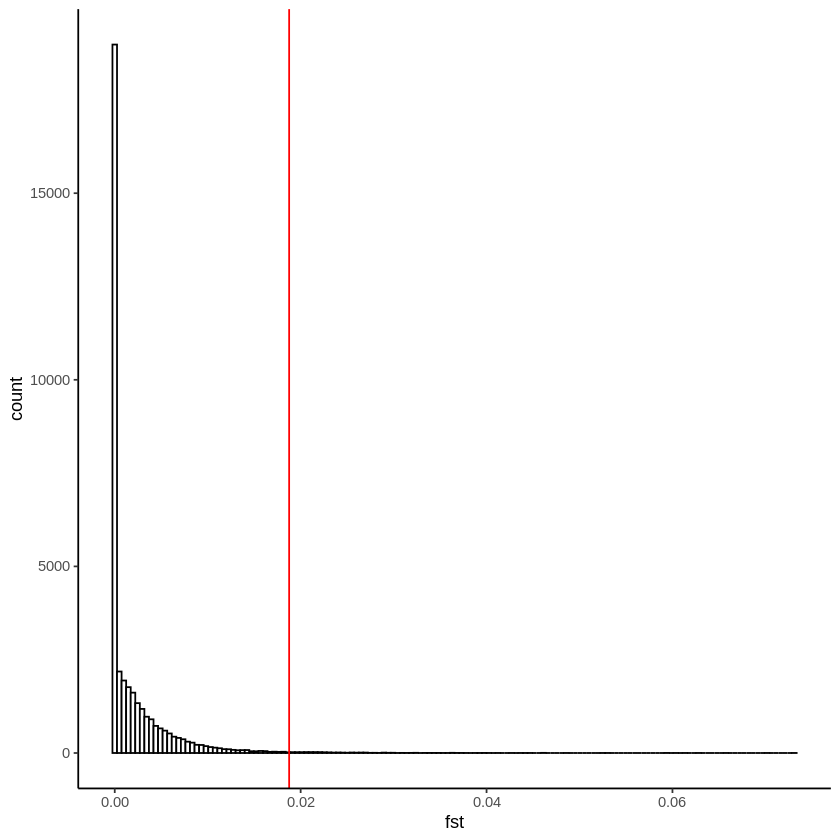

In [44]:
# Quick histogram of the distribution of windowed Fst values
# Red line is 99th percentile
# Use only windows with great than `nSites_thresh`
nSites_thresh <- 2000
testChr_allStats_filt <- testChr_allStats %>%
    filter_at(vars(starts_with('nSites')), ~ . >= nSites_thresh)

fst_quant_filt <- quantile(testChr_allStats_filt %>% pull(fst), probs = c(0.99))
tp_quant_filt <- quantile(testChr_allStats_filt %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
td_quant_filt <- quantile(testChr_allStats_filt %>% pull(delta_td_ur), probs = c(0.01, 0.99))

testChr_allStats_filt %>%
    ggplot(., aes(x = fst)) +
    geom_histogram(bins = 150, color = 'black', fill = 'white') +
    geom_vline(xintercept = fst_quant_filt, color = 'red') + 
    theme_classic()

In [45]:
testChr_allStats_filt <- testChr_allStats_filt %>%
    mutate(fst_outlier = ifelse(fst >= fst_quant_filt, 1, 0),
           tp_outlier = ifelse(delta_tp_ur <= tp_quant_filt[1] | delta_tp_ur >= tp_quant_filt[2], 1, 0),
           td_outlier = ifelse(delta_td_ur <= td_quant_filt[1] | delta_td_ur >= td_quant_filt[2], 1, 0),
           all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0))

In [46]:
testChr_allStats_filt %>% 
    group_by(fst_outlier, tp_outlier, td_outlier) %>%
    summarise(n = n())

`summarise()` has grouped output by 'fst_outlier', 'tp_outlier'. You can override using the `.groups` argument.


fst_outlier,tp_outlier,td_outlier,n
<dbl>,<dbl>,<dbl>,<int>
0,0,0,35885
0,0,1,514
0,1,0,543
0,1,1,136
1,0,0,260
1,0,1,44
1,1,0,15
1,1,1,56


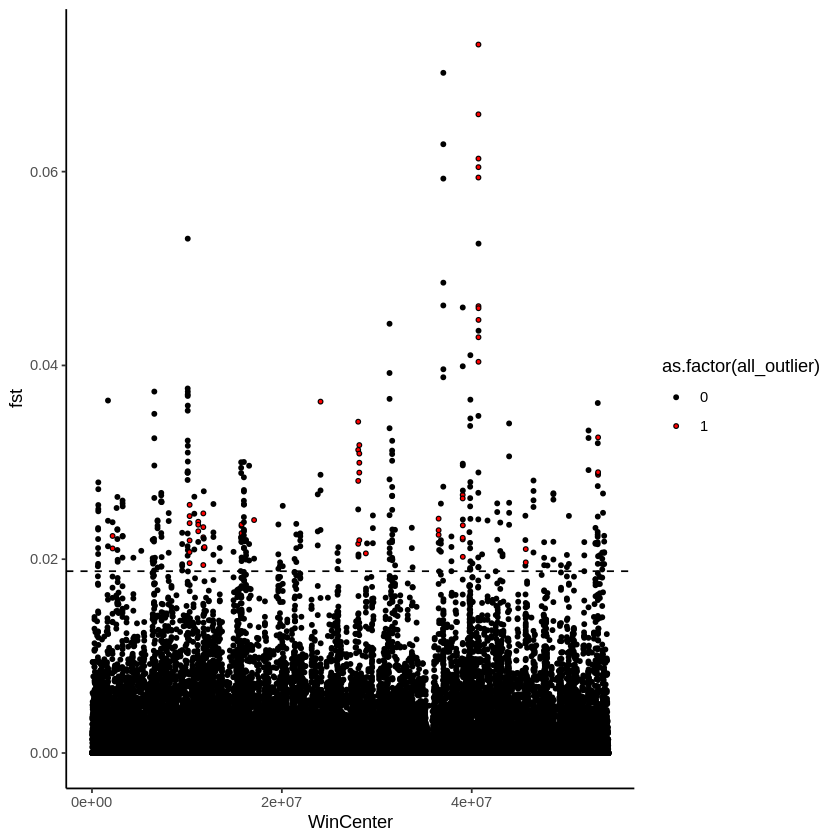

In [49]:
testChr_allStats_filt %>%
    ggplot(., aes(x = WinCenter, y = fst)) +
        geom_point(size = 1, shape = 21, aes(fill = as.factor(all_outlier))) +
        geom_hline(yintercept = fst_quant_filt, color = 'black', size = 0.5, linetype = 'dashed') +
        scale_fill_manual(values = c('black', 'red')) +
        theme_classic()

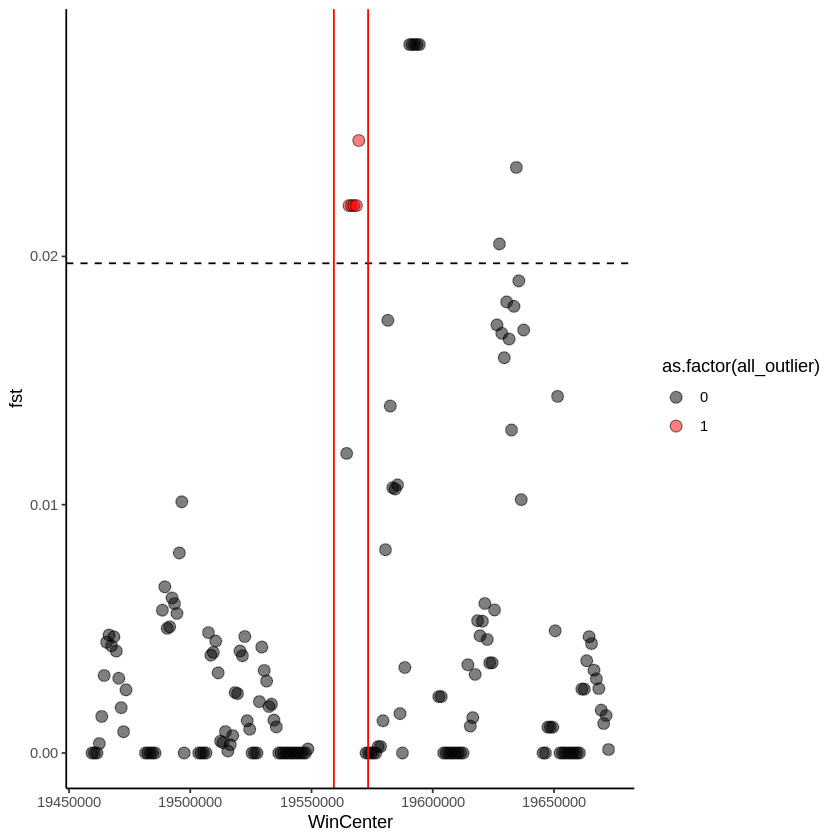

In [48]:
fst_quant <- quantile(testChr_allStats %>% pull(fst), probs = c(0.99))
tp_quant <- quantile(testChr_allStats %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
td_quant <- quantile(testChr_allStats %>% pull(delta_td_ur), probs = c(0.01, 0.99))
Ac_outlier_df <- testChr_allStats %>%
    filter(WinCenter >= 19559221 - 100000 & WinCenter <= 19573344 + 100000) %>%
    mutate(fst_outlier = ifelse(fst >= fst_quant, 1, 0),
           tp_outlier = ifelse(delta_tp_ur <= tp_quant[1] | delta_tp_ur >= tp_quant[2], 1, 0),
           td_outlier = ifelse(delta_td_ur <= td_quant[1] | delta_td_ur >= td_quant[2], 1, 0),
           all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0))
Ac_outlier_df %>%
    ggplot(., aes(x = WinCenter, y = fst)) +
        geom_point(size = 3, alpha = 0.5, shape = 21, aes(fill = as.factor(all_outlier))) +
        geom_hline(yintercept = fst_quant, color = 'black', size = 0.5, linetype = 'dashed') +
        scale_fill_manual(values = c('black', 'red')) +
        geom_vline(xintercept = 19559221, color = 'red') +
        geom_vline(xintercept = 19573344, color = 'red') + 
        theme_classic()